In [2]:
!pip -q install ultralytics  boto3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.8.0 requires botocore<1.33.2,>=1.32.4, but you have botocore 1.29.165 which is incompatible.


In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh
from ultralytics import YOLO

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
import json , boto3

In [14]:
# Load secrets
with open('/kaggle/input/aws-credentials/secrets.json') as f:
    secrets = json.load(f)

s3 = boto3.client(
    's3',
    aws_access_key_id = secrets['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key = secrets['AWS_SECRET_ACCESS_KEY'],
    region_name= secrets['AWS_DEFAULT_REGION']
)


## Loading the data

In [5]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv("/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv")

# change column name
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])

# preprocess the data for yolo object detection
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['status'] = 1

# scale the data
df['x_center'] = df['x_center'] / img_w
df['w'] = df['w'] / img_w
df['y_center'] = df['y_center'] / img_h
df['h'] = df['h'] / img_h

df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes,status
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0,1
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0,1
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0,1
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0,1
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0,1


In [6]:
if not os.path.exists(os.path.join('mydata', 'images')):
    os.makedirs(os.path.join('mydata', 'images'))

if not os.path.exists(os.path.join('mydata', 'labels')):
    os.makedirs(os.path.join('mydata', 'labels'))

for idx, data in df.groupby('image_id'):
    row = data[['classes', 'x_center', 'y_center', 'w', 'h']].astype(float).values
    row = row.astype(str) # ['0.0', '0.45043415340236687', '0.539816602368421','0.06874095502958583', '0.09523809526315791']
    
    with open('mydata/labels/{}.txt'.format(idx), 'w+') as f:
        for i in range(len(row)):
            text = ' '.join(row[i]) #0.0 0.45043415340236687 0.539816602368421 0.06874095502958583 0.09523809526315791
            f.write(text)
            f.write('\n')

    sh.copy(
      '/kaggle/input/car-object-detection/data/training_images/{}.jpg'.format(idx),
      'mydata/images/{}.jpg'.format(idx)
    )

## Importing the model

In [7]:
model = YOLO("yolo11m.pt") 

100%|██████████| 38.8M/38.8M [00:00<00:00, 110MB/s] 


## Training the model

In [8]:
with open('dataset.yaml', 'w+') as f:
    f.write('path: ../mydata\n')
    f.write('train: images\n')
    f.write('val: images\n\n')
    f.write('names:\n')
    f.write('  0: car')

In [9]:
model.train(data = 'dataset.yaml', epochs=20, imgsz=640 )

Ultralytics 8.3.112 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=dataset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, fo

100%|██████████| 755k/755k [00:00<00:00, 37.5MB/s]
2025-04-21 07:30:31,473	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-21 07:30:31,985	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 168MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2131.4±771.6 MB/s, size: 94.3 KB)


train: Scanning /kaggle/working/mydata/labels... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<00:00, 1421.98it/s]

train: New cache created: /kaggle/working/mydata/labels.cache



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1351.6±993.0 MB/s, size: 101.5 KB)


val: Scanning /kaggle/working/mydata/labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.89G      1.587      2.193       1.25          8        640: 100%|██████████| 23/23 [00:18<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]

                   all        355        559     0.0418      0.803     0.0409     0.0241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       7.9G      1.383      1.056      1.288          8        640: 100%|██████████| 23/23 [00:16<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.46it/s]

                   all        355        559    0.00409      0.667    0.00354     0.0017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.92G       1.38     0.8669       1.28          8        640: 100%|██████████| 23/23 [00:15<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]

                   all        355        559    0.00182       0.24    0.00113   0.000405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.92G      1.363     0.7942      1.265         10        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.49it/s]

                   all        355        559      0.538      0.757      0.585      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.92G      1.326     0.7415      1.265          7        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        355        559      0.746      0.585      0.632      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      7.92G      1.298     0.7319       1.23          8        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

                   all        355        559       0.91      0.888       0.95      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      7.92G      1.257     0.6971      1.229         12        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        355        559      0.576      0.222      0.235      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.92G      1.307     0.6757      1.244         11        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]

                   all        355        559       0.93      0.884      0.959      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      7.92G      1.281     0.6726      1.223          9        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]

                   all        355        559      0.945      0.884      0.944      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      7.92G      1.224     0.6369      1.179         20        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.49it/s]

                   all        355        559       0.93      0.943      0.981      0.587


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.92G      1.234     0.6239      1.227          5        640: 100%|██████████| 23/23 [00:17<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]

                   all        355        559      0.963      0.973      0.989      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      7.92G      1.228     0.6309      1.218          3        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        355        559      0.933      0.922      0.973      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.92G      1.289     0.6574       1.26          4        640: 100%|██████████| 23/23 [00:15<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

                   all        355        559      0.939      0.957      0.981      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.92G      1.216     0.6143        1.2          3        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        355        559      0.961      0.973       0.99      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.92G      1.189     0.5784      1.217          7        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        355        559      0.957       0.95      0.981       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.92G       1.19     0.5738      1.216          3        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        355        559      0.973      0.979      0.989       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.92G      1.173     0.5797      1.187          4        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]

                   all        355        559      0.978      0.974      0.993      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.92G      1.133     0.5371      1.172          6        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        355        559      0.983      0.982      0.994       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.92G      1.138     0.5321      1.177          3        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        355        559      0.982      0.986      0.992      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      7.92G      1.115     0.5226       1.15          9        640: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        355        559      0.986      0.987      0.994      0.704



20 epochs completed in 0.113 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


                   all        355        559      0.989      0.986      0.994      0.704
Speed: 0.5ms preprocess, 8.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bccc40acf70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## Validating the model

In [10]:
img = os.path.join('mydata', 'images', 'vid_4_26460.jpg')
results = model(img)
print(results)


image 1/1 /kaggle/working/mydata/images/vid_4_26460.jpg: 384x640 7 cars, 69.4ms
Speed: 1.6ms preprocess, 69.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'car'}
obb: None
orig_img: array([[[226, 147,  84],
        [226, 147,  84],
        [226, 148,  82],
        ...,
        [214, 131,  69],
        [216, 133,  71],
        [217, 134,  72]],

       [[226, 147,  84],
        [226, 147,  84],
        [226, 148,  82],
        ...,
        [217, 134,  72],
        [218, 135,  73],
        [218, 135,  73]],

       [[227, 149,  83],
        [227, 149,  83],
        [227, 149,  83],
        ...,
        [218, 135,  73],
        [218, 135,  73],
        [217, 134,  72]],

       ...,

       [[ 37,  20,  11],
        [ 38,  21,  12],
        [ 38,  21,  12],
        ...,
        [ 32,  17,   8],
        [ 32,  17,   8],
  

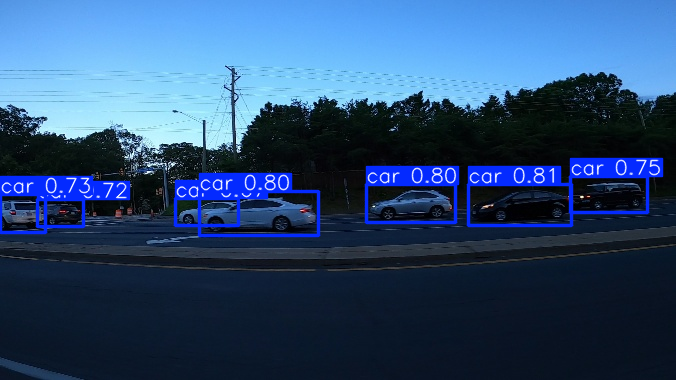

In [11]:
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    #im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Show results to screen (in supported environments)
    r.show()


## Exporting the model

In [12]:
model.export()

Ultralytics 8.3.112 🚀 Python-3.10.12 torch-2.0.0 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (38.6 MB)

TorchScript: starting export with torch 2.0.0...
TorchScript: export success ✅ 5.2s, saved as 'runs/detect/train/weights/best.torchscript' (77.1 MB)

Export complete (7.8s)
Results saved to /kaggle/working/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.torchscript imgsz=640 data=dataset.yaml  
Visualize:       https://netron.app


'runs/detect/train/weights/best.torchscript'

## Upload the model to s3

In [15]:
bucket_name = 'mlops-udemy-course-aws'

def upload_directory(directory_path, s3_prefix):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file).replace("\\", "/")
            relpath = os.path.relpath(file_path, directory_path)
            s3_key = os.path.join(s3_prefix, relpath).replace("\\", "/")
            
            s3.upload_file(file_path, bucket_name, s3_key)


upload_directory('/kaggle/working/runs/detect/train/weights', 'ml-models/yolov11m')